In [360]:
import numpy as np
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as ptchs
from matplotlib import gridspec
import matplotlib.text as mtext

import scipy.integrate
import scipy.optimize
from sklearn.linear_model import Ridge

import pandas as pd
from pandas.core.base import PandasObject

pred_style = {"marker": "s", "markersize":7, "markerfacecolor":'none'}
sum_style = {"marker": "s", "markersize":7, "ls":":"}
bm_style = {"marker": "s", "markersize":5}
vd_style = {"marker": "s", "markersize":7}
sl_style = {"marker": "o", "color":"k", "ms":14, "markerfacecolor":"None"}

colors = mpl.rcParams['axes.prop_cycle'].by_key()['color'] 
ecolors=["b", "r", "g", "brown"]
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) 

# import mplhep as hep
# hep.style.use(hep.style.ROOT) # For now ROOT defaults to CMS

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, r'\textbf{' + orig_handle + '}', usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title

class LightLegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LightLegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle, usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title

def fill_between_edges(ax, X, ymin, ymax, facecolor, edgecolor, label="", **kwargs):
    ax.fill_between(X, ymin, ymax, alpha=0.8, color=facecolor, **kwargs)
    ax.fill_between(X, ymin, ymax, facecolor="none", edgecolors=edgecolor, **kwargs)
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=facecolor, edgecolor=edgecolor, label=label))

In [361]:
class MinorSymLogLocator(ticker.Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))

In [362]:
def convert_to_type(df, col, type):
    df[col] =  df[col].apply(lambda s: type(s) if pd.notnull(s) else s)

def normalize_df(df, cols, norm):
    for col in cols:
        df[col] = df[col].div(df[norm])

def unique_non_nan(df):
    return df.dropna().unique()
PandasObject.unique_non_nan = unique_non_nan

def map_distr_name(distr):
    s = distr.split("-")
    n = distr
    if "constant" in distr:
        n = f"{s[0]}({s[1]})"
    elif "normal" in distr:
        n = f"{s[0]}({s[1]}, {s[2]})"
    return n.title()

def human_readable(val, bytes=False):
    factor = 1024 if bytes else 1e3
    if int(val/pow(factor, 3)) > 0:
        return f"{int(val/pow(factor, 3))}B"
    elif int(val/pow(factor, 2)) > 0:
        return f"{int(val/pow(factor, 2))}M"
    elif int(val/pow(factor, 1)) > 0:
        return f"{int(val/pow(factor, 1))}K"
    else:
        return str(int(val))
        
def convert_unit(x):
    """
    Get factor to convert to seconds
    """
    if x == "s":
        return 1
    elif x == "ms":
        return 1e3
    elif x == "us":
        return 1e6
    elif x == "ns":
        return 1e9

def unit_to_unit_factor(u1, u2):
    f1 = convert_unit(u1)
    f2 = convert_unit(u2)
    return f2/f1

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e

def mae(pred, observ):
    return np.sum(np.abs(pred-observ))/len(pred)

def r2(pred, observ):
    return 1- (np.sum(np.power(pred-observ, 2)) / np.sum(np.power(observ - np.mean(observ), 2)))

In [363]:
def filter_name(n):
    # print(n)
    name_map = {
        "Stats" : "UpdateStats",
        "Reduce" : "UpdateStats",
        "Histo" : "FindBin + AddBinContent",
        "ExcludeUOverflowKernel" : "Other",
        "InitializeToZeroTask" : "Other",
        "Host-to-Device" : "HtoD",
        "Device-to-Host" : "DtoH",
        "CUDAmemset" : "Memset",
    }
    for w in ["unsigned", "int", "char", "float", "void", "const", "long", "*", "hipsycl_kernel",
              "::operator", "ROOT::", "Experimental::", "_", "::", "]", "[", "  "]:
        n = n.replace(w, "")
    for k,v in name_map.items():
        if k in n:
            n = v

    return n.strip()

def get_cell(df, index_name, col):
    return df.loc[index_name][col]
    
def fill_bar(h, x, w, d, c, s):
    h.Fill(x, w)
    h.SetBinError(h.FindBin(x), d)
    if s:
        h.SetFillStyle(s)
    h.SetLineColor(c)
    h.SetFillColor(c)
    h.SetLineWidth(2)
    h.SetMarkerSize(0)

# default_clr = ROOT.kGray+2
def get_group(n):
    if n in [
        "cuModuleLoadDataEx",
        "cuModuleUnload",
        "cuModuleGetLoadingMode",
        "cuCtxSetCurrent",
    ]:
        return "Module"
    elif n in [
        "cuEventCreate",
        "cuEventDestroy_v2",
        "cuEventQuery",
        "cuEventRecord",
        "cuEventSynchronize",
        "cudaEventCreate",
        "cudaEventDestroy",
        "cudaEventRecord",
        "cudaEventSynchronize",
    ]:
        return "Event"
    elif n in [
        "cuMemAlloc_v2",
        "cuMemFree_v2",
        "cuMemcpyAsync",
        "cuMemcpyHtoDAsync_v2",
        "cuMemcpyDtoHAsync_v2",
        "cuMemsetAsync",
        "cudaMalloc",
        "cudaFree",
        "cudaMemcpyAsync",
        "cudaMemsetAsync",
        "cuMemsetD8Async",
        "CUDAMalloc",
        "CUDAFree",
        "cudaMemcpy",
        "cudaMemset",
    ]:
        return "Memory"
    elif n in [
        "cuStreamWaitEvent",
        "cuStreamCreateWithPriority",
        "cuStreamDestroy_v2",
        "cuStreamCreateWithFlags",
        "cudaStreamCreateWithFlags",
        "cudaStreamDestroy",
        "cudaStreamWaitEvent",
        "cuStreamSynchronize",
    ]:
        return "Stream"
    elif n in [
        "cuLaunchKernel",
        "cudaLaunchKernel",
        "CUDALaunchKernel",
    ]:
        return "Kernel"
    elif n in [
        "cuGetDevicePropertiesv2v12000",
        "cudaGetDeviceProperties_v2_v12000",
    ]:
        return "Properties"

In [364]:
a4000_maxsmem = 49152 # 48 KB
a4000_l2_size = 4194304 # 48 KB
a4000_l2_persistent_size = 3145728 # 48 KB

# Validation Data

In [365]:
validation_results = "das6-gpu/validation_1" 
validation_df = pd.read_csv(validation_results)
validation_df["nvals"] =  validation_df["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
validation_df["distribution"] = validation_df["input"].apply(lambda s: s.split("_")[1])
validation_df["env"] = validation_df["env"].apply(map_env)
convert_to_type(validation_df, "edges", np.bool_)
convert_to_type(validation_df, "nvals", np.int64)
convert_to_type(validation_df, "nbins", np.int64)
del validation_df["input"]
validation_df

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,1.291421,50000000,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,2.370882,100000000,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,7.550797,500000000,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,19.217439,1000000000,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,1.386995,50000000,normal-0.7-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,9.661184,1000000000,normal-0.4-0.1
2876,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,0.579388,50000000,normal-0.7-0.01
2877,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,1.544344,100000000,normal-0.7-0.01
2878,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,4.880793,500000000,normal-0.7-0.01


In [366]:
groupby_list = ["env", "gpu", "distribution", "nvals", "nbins", "bulksize", "edges"]

In [367]:
gp_vd = validation_df.groupby([*groupby_list])
gp_vd.mean()

iter    cc  \
env  gpu   distribution    nvals      nbins    bulksize  edges               
CUDA A4000 normal-0.4-0.1  50000000   10       8192      False   2.0  86.0   
                                                         True    2.0  86.0   
                                               16384     False   2.0  86.0   
                                                         True    2.0  86.0   
                                               32768     False   2.0  86.0   
...                                                              ...   ...   
           normal-0.7-0.01 1000000000 10000000 2097152   True    2.0  86.0   
                                               16777216  False   2.0  86.0   
                                                         True    2.0  86.0   
                                               134217728 False   2.0  86.0   
                                                         True    2.0  86.0   

                                                                blocksize  \
env  gpu   distribution    nvals      nbins    bulksize  edges              
CUDA A4000 normal-0.4-0.1  50000000   10       8192      False      256.0   
                                                         True       256.0   
                                               16384     False      256.0   
                                                         True       256.0   
                                               32768     False      256.0   
...                                                                   ...   
           normal-0.7-0.01 1000000000 10000000 2097152   True       256.0   
                                               16777216  False      256.0   
                                                         True       256.0   
                                               134217728 False      256.0   
                                                         True       256.0   

                                                                tfindbin  \
env  gpu   distribution    nvals      nbins    bulksize  edges             
CUDA A4000 normal-0.4-0.1  50000000   10       8192      False       0.0   
                                                         True        0.0   
                                               16384     False       0.0   
                                                         True        0.0   
                                               32768     False       0.0   
...                                                                  ...   
           normal-0.7-0.01 1000000000 10000000 2097152   True        0.0   
                                               16777216  False       0.0   
                                                         True        0.0   
                                               134217728 False       0.0   
                                                         True        0.0   

                                                                tfill  tstats  \
env  gpu   distribution    nvals      nbins    bulksize  edges                  
CUDA A4000 normal-0.4-0.1  50000000   10       8192      False    0.0     0.0   
                                                         True     0.0     0.0   
                                               16384     False    0.0     0.0   
                                                         True     0.0     0.0   
                                               32768     False    0.0     0.0   
...                                                               ...     ...   
           normal-0.7-0.01 1000000000 10000000 2097152   True     0.0     0.0   
                                               16777216  False    0.0     0.0   
                                                         True     0.0     0.0   
                                               134217728 False    0.0     0.0   
                                                         True     0.0     0.0   

    

In [368]:
unique_env = validation_df["env"].unique()
unique_bulksize = np.sort(validation_df["bulksize"].unique())
unique_nbins = np.sort(validation_df["nbins"].unique())
unique_nvals = np.sort(validation_df["nvals"].unique().astype(np.float64))
unique_gpus = validation_df["gpu"].unique()
unique_distributions = validation_df["distribution"].unique()
unique_edges = [True, False]
unique_env, unique_gpus, unique_nbins, unique_bulksize, unique_edges, unique_nvals, unique_distributions

(array(['CUDA'], dtype=object),
 array(['A4000'], dtype=object),
 array([      10,     1000,   100000, 10000000]),
 array([     8192,     16384,     32768,     65536,    131072,    262144,
          2097152,  16777216, 134217728]),
 [True, False],
 array([5.e+07, 1.e+08, 5.e+08, 1.e+09]),
 array(['normal-0.4-0.1', 'normal-0.7-0.01'], dtype=object))

In [369]:
api_buf = pd.read_csv("das6-gpu/nsys-validation_1/api")
api_buf["nvals"] =  api_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
api_buf["distribution"] =  api_buf["input"].apply(lambda s: s.split("_")[1])
api_buf["env"] = api_buf["env"].apply(map_env)
convert_to_type(api_buf, "edges", np.bool_)
del api_buf["input"]
api_buf

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,Time (%),Total Time (ns),Num Calls,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Name,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,49.0,448620130,61080,7344.8,6602.0,5691,36650198,148276.8,cudaLaunchKernel,5.000000e+07,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,24.6,225013621,12222,18410.5,20608.5,6121,528369,8181.6,cudaMemcpy,5.000000e+07,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,20.8,190855173,10,19085517.3,7243.5,4088,190793145,60331910.6,cudaMalloc,5.000000e+07,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,5.6,50940094,6110,8337.2,8185.0,4348,72095,1551.9,cudaMemset,5.000000e+07,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,0.1,481281,10,48128.1,6276.5,4188,409526,127133.1,cudaFree,5.000000e+07,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20155,4,CUDA,A4000,86,10000000,134217728,True,256,2.7,31296401,1260,24838.4,5029.5,3376,23695065,667375.5,cudaLaunchKernel,1.000000e+09,normal-0.7-0.01
20156,4,CUDA,A4000,86,10000000,134217728,True,256,0.8,9513184,11,864834.9,305681.0,2805,2825877,1113072.6,cudaFree,1.000000e+09,normal-0.7-0.01
20157,4,CUDA,A4000,86,10000000,134217728,True,256,0.4,4522590,128,35332.7,34549.5,5380,76253,5974.2,cudaMemset,1.000000e+09,normal-0.7-0.01
20158,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,100958,1,100958.0,100958.0,100958,100958,0.0,cudaGetDeviceProperties_v2_v12000,1.000000e+09,normal-0.7-0.01


In [370]:
gp_api = api_buf.groupby([*groupby_list, "Name"])
gp_api.mean()

iter  \
env  gpu   distribution    nvals        nbins    bulksize  edges Name                                      
CUDA A4000 normal-0.4-0.1  5.000000e+07 10       8192      False cuModuleGetLoadingMode              2.0   
                                                                 cudaFree                            2.0   
                                                                 cudaGetDeviceProperties_v2_v12000   2.0   
                                                                 cudaLaunchKernel                    2.0   
                                                                 cudaMalloc                          2.0   
...                                                                                                  ...   
           normal-0.7-0.01 1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000   2.0   
                                                                 cudaLaunchKernel                    2.0   
                                                                 cudaMalloc                          2.0   
                                                                 cudaMemcpy                          2.0   
                                                                 cudaMemset                          2.0   

                                                                                                      cc  \
env  gpu   distribution    nvals        nbins    bulksize  edges Name                                      
CUDA A4000 normal-0.4-0.1  5.000000e+07 10       8192      False cuModuleGetLoadingMode             86.0   
                                                                 cudaFree                           86.0   
                                                                 cudaGetDeviceProperties_v2_v12000  86.0   
                                                                 cudaLaunchKernel                   86.0   
                                                                 cudaMalloc                         86.0   
...                                                                                                  ...   
           normal-0.7-0.01 1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000  86.0   
                                                                 cudaLaunchKernel                   86.0   
                                                                 cudaMalloc                         86.0   
                                                                 cudaMemcpy                         86.0   
                                                                 cudaMemset                         86.0   

                                                                                                    blocksize  \
env  gpu   distribution    nvals        nbins    bulksize  edges Name                                           
CUDA A4000 normal-0.4-0.1  5.000000e+07 10       8192      False cuModuleGetLoadingMode                 256.0   
                                                                 cudaFree                               256.0   
                                                                 cudaGetDeviceProperties_v2_v12000      256.0   
                                                                 cudaLaunchKernel                       256.0   
                                                                 cudaMalloc                             256.0   
...                                                                                                       ...   
           normal-0.7-0.01 1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000      256.0   
                                                                 cudaLaunchKernel                       256.0   
                                                                 cudaMalloc                             256.0   
                                               

In [371]:
kernel_buf = pd.read_csv("das6-gpu/nsys-validation_1/kernel")
kernel_buf["nvals"] =  kernel_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
kernel_buf["distribution"] =  kernel_buf["input"].apply(lambda s: s.split("_")[1])
kernel_buf["env"] = kernel_buf["env"].apply(map_env)
convert_to_type(kernel_buf, "edges", np.bool_)
del kernel_buf["input"]
kernels_unfiltered = kernel_buf.copy()
kernel_buf["Name"] = kernel_buf["Name"].apply(filter_name)
kernel_buf

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,Time (%),Total Time (ns),Instances,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Name,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,32.7,145665865,6108,23848.4,23776.0,21825,26880,578.2,FindBin + AddBinContent,5.000000e+07,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,29.9,133215898,24404,5458.8,5472.0,5407,5568,22.1,UpdateStats,5.000000e+07,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,8.7,38912425,6101,6378.0,6368.0,6303,6625,29.8,UpdateStats,5.000000e+07,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,8.2,36472816,6101,5978.2,5984.0,5888,6304,30.1,UpdateStats,5.000000e+07,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,8.1,36149959,6101,5925.3,5920.0,5855,6208,29.2,UpdateStats,5.000000e+07,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35475,4,CUDA,A4000,86,10000000,134217728,True,256,5.1,40383688,126,320505.5,321344.0,8256,498304,32179.6,UpdateStats,1.000000e+09,normal-0.7-0.01
35476,4,CUDA,A4000,86,10000000,134217728,True,256,2.8,21749572,126,172615.7,173120.0,8000,261664,16768.7,UpdateStats,1.000000e+09,normal-0.7-0.01
35477,4,CUDA,A4000,86,10000000,134217728,True,256,2.7,20984552,126,166544.1,166976.0,7552,257856,16425.0,UpdateStats,1.000000e+09,normal-0.7-0.01
35478,4,CUDA,A4000,86,10000000,134217728,True,256,0.3,2480392,500,4960.8,4912.0,4512,5632,371.5,UpdateStats,1.000000e+09,normal-0.7-0.01


In [372]:
gp_kernels = kernel_buf.groupby([*groupby_list, "Name"])
gp_kernels_unfiltered = kernels_unfiltered.groupby([*groupby_list, "Name"])
gp_kernels.mean()

iter  \
env  gpu   distribution    nvals        nbins    bulksize  edges Name                            
CUDA A4000 normal-0.4-0.1  5.000000e+07 10       8192      False FindBin + AddBinContent   2.0   
                                                                 Other                     2.0   
                                                                 UpdateStats               2.0   
                                                           True  FindBin + AddBinContent   2.0   
                                                                 Other                     2.0   
...                                                                                        ...   
           normal-0.7-0.01 1.000000e+09 10000000 134217728 False Other                     2.0   
                                                                 UpdateStats               2.0   
                                                           True  FindBin + AddBinContent   2.0   
                                                                 Other                     2.0   
                                                                 UpdateStats               2.0   

                                                                                            cc  \
env  gpu   distribution    nvals        nbins    bulksize  edges Name                            
CUDA A4000 normal-0.4-0.1  5.000000e+07 10       8192      False FindBin + AddBinContent  86.0   
                                                                 Other                    86.0   
                                                                 UpdateStats              86.0   
                                                           True  FindBin + AddBinContent  86.0   
                                                                 Other                    86.0   
...                                                                                        ...   
           normal-0.7-0.01 1.000000e+09 10000000 134217728 False Other                    86.0   
                                                                 UpdateStats              86.0   
                                                           True  FindBin + AddBinContent  86.0   
                                                                 Other                    86.0   
                                                                 UpdateStats              86.0   

                                                                                          blocksize  \
env  gpu   distribution    nvals        nbins    bulksize  edges Name                                 
CUDA A4000 normal-0.4-0.1  5.000000e+07 10       8192      False FindBin + AddBinContent      256.0   
                                                                 Other                        256.0   
                                                                 UpdateStats                  256.0   
                                                           True  FindBin + AddBinContent      256.0   
                                                                 Other                        256.0   
...                                                                                             ...   
           normal-0.7-0.01 1.000000e+09 10000000 134217728 False Other                        256.0   
                                                                 UpdateStats                  256.0   
                                                           True  FindBin + AddBinContent      256.0   
                                                                 Other                        256.0   
                                                                 UpdateStats                  256.0   

                                                                                           Time (%)  \
env  gpu   distribution    nvals        nbins    bulksize  edges Name                            

In [373]:
memops_buf = pd.read_csv("das6-gpu/nsys-validation_1/memop")
memops_buf["nvals"] =  memops_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
memops_buf["distribution"] =  memops_buf["input"].apply(lambda s: s.split("_")[1])
memops_buf["env"] = memops_buf["env"].apply(map_env)
convert_to_type(memops_buf, "edges", np.bool_)
del memops_buf["input"]
memops_buf["Operation"] = memops_buf["Operation"].apply(filter_name)
memops_buf

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,Time (%),Total Time (ns),Count,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Operation,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,86.1,107810209,12220,8822.4,9024.0,896,9504,433.3,HtoD,5.000000e+07,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,13.9,17462218,6110,2858.0,2848.0,896,3360,66.7,CUDA memset,5.000000e+07,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,0.0,3744,2,1872.0,1872.0,1856,1888,22.6,DtoH,5.000000e+07,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,84.2,142574435,24440,5833.7,5792.0,512,6752,236.5,HtoD,1.000000e+08,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,15.8,26832872,12220,2195.8,2208.0,512,2752,58.8,CUDA memset,1.000000e+08,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,4,CUDA,A4000,86,10000000,134217728,True,256,1.4,7506819,2,3753409.5,3753409.5,2688,7504131,5304321.2,DtoH,5.000000e+08,normal-0.7-0.01
8636,4,CUDA,A4000,86,10000000,134217728,True,256,0.3,1681066,65,25862.6,22976.0,928,233953,26515.0,CUDA memset,5.000000e+08,normal-0.7-0.01
8637,4,CUDA,A4000,86,10000000,134217728,True,256,99.0,1027135429,257,3996635.9,4114370.0,512,7180194,771679.9,HtoD,1.000000e+09,normal-0.7-0.01
8638,4,CUDA,A4000,86,10000000,134217728,True,256,0.7,7469347,2,3734673.5,3734673.5,1728,7467619,5279182.2,DtoH,1.000000e+09,normal-0.7-0.01


In [374]:
gp_memops = memops_buf.groupby([*groupby_list, "Operation"])
gp_memops.mean()

iter  \
env  gpu   distribution    nvals        nbins    bulksize  edges Operation           
CUDA A4000 normal-0.4-0.1  5.000000e+07 10       8192      False CUDA memset   2.0   
                                                                 DtoH          2.0   
                                                                 HtoD          2.0   
                                                           True  CUDA memset   2.0   
                                                                 DtoH          2.0   
...                                                                            ...   
           normal-0.7-0.01 1.000000e+09 10000000 134217728 False DtoH          2.0   
                                                                 HtoD          2.0   
                                                           True  CUDA memset   2.0   
                                                                 DtoH          2.0   
                                                                 HtoD          2.0   

                                                                                cc  \
env  gpu   distribution    nvals        nbins    bulksize  edges Operation           
CUDA A4000 normal-0.4-0.1  5.000000e+07 10       8192      False CUDA memset  86.0   
                                                                 DtoH         86.0   
                                                                 HtoD         86.0   
                                                           True  CUDA memset  86.0   
                                                                 DtoH         86.0   
...                                                                            ...   
           normal-0.7-0.01 1.000000e+09 10000000 134217728 False DtoH         86.0   
                                                                 HtoD         86.0   
                                                           True  CUDA memset  86.0   
                                                                 DtoH         86.0   
                                                                 HtoD         86.0   

                                                                              blocksize  \
env  gpu   distribution    nvals        nbins    bulksize  edges Operation                
CUDA A4000 normal-0.4-0.1  5.000000e+07 10       8192      False CUDA memset      256.0   
                                                                 DtoH             256.0   
                                                                 HtoD             256.0   
                                                           True  CUDA memset      256.0   
                                                                 DtoH             256.0   
...                                                                                 ...   
           normal-0.7-0.01 1.000000e+09 10000000 134217728 False DtoH             256.0   
                                                                 HtoD             256.0   
                                                           True  CUDA memset      256.0   
                                                                 DtoH             256.0   
                                                                 HtoD             256.0   

                                                                              Time (%)  \
env  gpu   distribution    nvals        nbins    bulksize  edges Operation               
CUDA A4000 normal-0.4-0.1  5.000000e+07 10       8192      False CUDA memset     12.96   
                                                                 DtoH             0.00   
                                                                 HtoD            87.04   
                                                           True  CUDA memset     12.30   
                                                                 DtoH             0.00   
...                       

# Find Bin

## Design

In [375]:
filename = "../microbenchmarks/das6/binarysearch_gpu.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
bsbm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(bsbm_df, "real_time", np.float64)
bsbm_df["func_name"] = bsbm_df["name"].apply(lambda s: s.split("/")[0][3:])    
bsbm_df["time_factor"] = bsbm_df["time_unit"].apply(convert_unit)
del bsbm_df["family_index"], bsbm_df["per_family_instance_index"],  bsbm_df["run_name"], bsbm_df["threads"], bsbm_df["run_type"], bsbm_df["aggregate_unit"]
bsbm_df["time_factor"] = bsbm_df["time_unit"].apply(convert_unit)

bsbm_df.head(10)

,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,nbins,numblocks,val,func_name,time_factor
0,BM_BinarySearchGPUConstant/8/32/32/0/manual_ti...,10.0,mean,3,44.540952,0.052153,ms,32.0,32.0,1.0,1.0,0.0,BinarySearchGPUConstant,1000.0
1,BM_BinarySearchGPUConstant/8/32/32/0/manual_ti...,10.0,median,3,44.617143,0.052288,ms,32.0,32.0,1.0,1.0,0.0,BinarySearchGPUConstant,1000.0
2,BM_BinarySearchGPUConstant/8/32/32/0/manual_ti...,0.0,stddev,3,0.194398,0.000258,ms,0.0,0.0,0.0,0.0,0.0,BinarySearchGPUConstant,1000.0
3,BM_BinarySearchGPUConstant/8/32/32/0/manual_ti...,0.0,cv,3,0.004364,0.004951,ms,0.0,0.0,0.0,0.0,NaN,BinarySearchGPUConstant,1000.0
4,BM_BinarySearchGPUConstant/16/32/32/0/manual_t...,10.0,mean,3,44.302476,0.052001,ms,32.0,32.0,2.0,1.0,0.0,BinarySearchGPUConstant,1000.0
5,BM_BinarySearchGPUConstant/16/32/32/0/manual_t...,10.0,median,3,44.329143,0.052159,ms,32.0,32.0,2.0,1.0,0.0,BinarySearchGPUConstant,1000.0
6,BM_BinarySearchGPUConstant/16/32/32/0/manual_t...,0.0,stddev,3,0.185444,0.000302,ms,0.0,0.0,0.0,0.0,0.0,BinarySearchGPUConstant,1000.0
7,BM_BinarySearchGPUConstant/16/32/32/0/manual_t...,0.0,cv,3,0.004186,0.005817,ms,0.0,0.0,0.0,0.0,NaN,BinarySearchGPUConstant,1000.0
8,BM_BinarySearchGPUConstant/32/32/32/0/manual_t...,10.0,mean,3,44.713333,0.052379,ms,32.0,32.0,4.0,1.0,0.0,BinarySearchGPUConstant,1000.0
9,BM_BinarySearchGPUConstant/32/32/32/0/manual_t...,10.0,median,3,44.606000,0.052271,ms,32.0,32.0,4.0,1.0,0.0,BinarySearchGPUConstant,1000.0


In [376]:
n_param = len(bsbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        bsbm_df[f"param_{i}"] = bsbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0] if i+1 < len(s.split("_/")) else None)
    else:
        bsbm_df[f"param_{i}"] = bsbm_df["name"].apply(lambda s: s.split("/")[i+1] if i+1 < len(s.split("/")) else None)

convert_to_type(bsbm_df, "nbins", np.int64)
convert_to_type(bsbm_df, "param_1", np.int64)
convert_to_type(bsbm_df, "param_2", np.int64)
convert_to_type(bsbm_df, "blocksize", np.int64)

bsbm_mean = bsbm_df.loc[bsbm_df["aggregate_name"] == "mean"].reset_index()
bsbm_std = bsbm_df.loc[bsbm_df["aggregate_name"] == "stddev"].reset_index()
# convert_to_type(
bsbm_mean

,index,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,nbins,numblocks,val,func_name,time_factor,param_0,param_1,param_2,param_3,param_4
0,0,BM_BinarySearchGPUConstant/8/32/32/0/manual_ti...,10.0,mean,3,44.540952,0.052153,ms,32,32.0,1,1.0,0.0,BinarySearchGPUConstant,1000.0,8,32,32,0,None
1,4,BM_BinarySearchGPUConstant/16/32/32/0/manual_t...,10.0,mean,3,44.302476,0.052001,ms,32,32.0,2,1.0,0.0,BinarySearchGPUConstant,1000.0,16,32,32,0,None
2,8,BM_BinarySearchGPUConstant/32/32/32/0/manual_t...,10.0,mean,3,44.713333,0.052379,ms,32,32.0,4,1.0,0.0,BinarySearchGPUConstant,1000.0,32,32,32,0,None
3,12,BM_BinarySearchGPUConstant/64/32/32/0/manual_t...,10.0,mean,3,44.605333,0.052525,ms,32,32.0,8,1.0,0.0,BinarySearchGPUConstant,1000.0,64,32,32,0,None
4,16,BM_BinarySearchGPUConstant/128/32/32/0/manual_...,10.0,mean,3,45.555200,0.053465,ms,32,32.0,16,1.0,0.0,BinarySearchGPUConstant,1000.0,128,32,32,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,34924,BM_BinarySearchGPURandom/16777216/262144/1024/...,10.0,mean,3,3479.552031,3.834484,ms,1024,262144.0,2097152,256.0,NaN,BinarySearchGPURandom,1000.0,16777216,262144,1024,manual_time_mean,None
8732,34928,BM_BinarySearchGPURandom/33554432/262144/1024/...,10.0,mean,3,4542.463938,5.008369,ms,1024,262144.0,4194304,256.0,NaN,BinarySearchGPURandom,1000.0,33554432,262144,1024,manual_time_mean,None
8733,34932,BM_BinarySearchGPURandom/67108864/262144/1024/...,10.0,mean,3,6950.570742,7.654342,ms,1024,262144.0,8388608,256.0,NaN,BinarySearchGPURandom,1000.0,67108864,262144,1024,manual_time_mean,None
8734,34936,BM_BinarySearchGPURandom/134217728/262144/1024...,10.0,mean,3,8346.965154,9.179454,ms,1024,262144.0,16777216,256.0,NaN,BinarySearchGPURandom,1000.0,134217728,262144,1024,manual_time_mean,None


<function matplotlib.pyplot.show(close=None, block=None)>

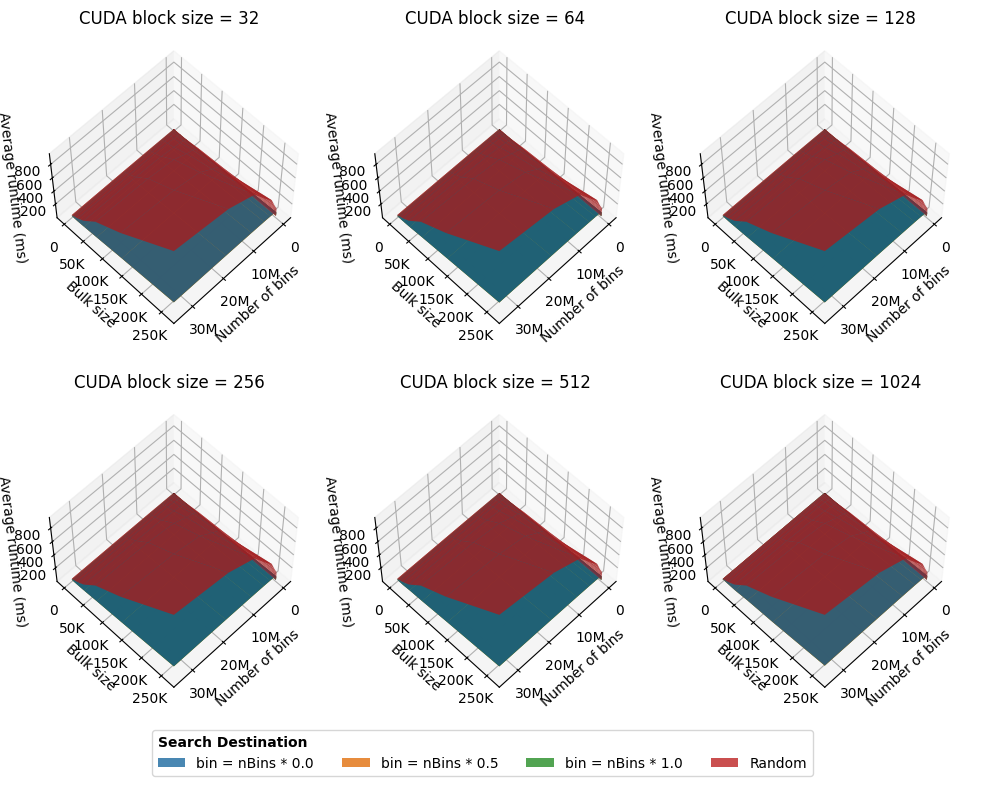

In [377]:
# figname = "../../images/gpu_binsearchconstant_mb_3d.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 1024
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={"projection": "3d"}, figsize=(10, 10))
for bi, bs in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["blocksize"].unique()):
    ax = axs[int(bi/3), bi%3]
    for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
        ax.set_title(f"CUDA block size = {bs}")
        arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
               & (bsbm_mean["param_3"] == dest) 
               & (bsbm_mean["blocksize"] == bs)
              )
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]
        X = avg["nbins"].unique()
        Y = avg["bulksize"].unique() # bulksize
        Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                         # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                        alpha=0.8,
                        label=f"bin = nBins * {int(dest)/4.}")


    arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    X = avg["nbins"].unique()
    Y = avg["bulksize"].unique() # bulksize
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                 # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                    alpha=0.8,
                    label=f"Random",
                )

    ax.set_xlabel("Number of bins")
    # ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel("Bulk size")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_zlabel(f"Average runtime ({unit})")
    # ax.set_yscale("log", base=2)
    # ax.set_zlim(3, 10)
    ax.zaxis.labelpad=-0.7 # <- change the value here
    ax.view_init(elev=60, azim=45, roll=0)
    ax.set_box_aspect(aspect=None, zoom=0.83)

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

# plt.savefig(figname, format="pdf", bbox_inches='tight')
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show

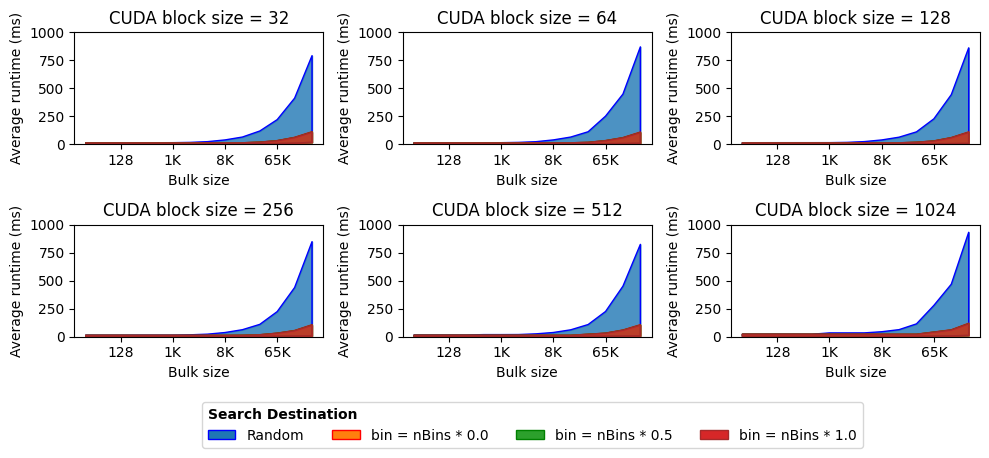

In [378]:
figname = "../../images/gpu_binsearch_mb_variance.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 1024
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))
for bi, bs in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["blocksize"].unique()):
    ax = axs[int(bi/3), bi%3]
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
           & (bsbm_mean["blocksize"] == bs))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    
    xname = "bulksize"
    X = sorted(avg[xname].unique())
    ymax = []; ymin = []
    norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    for bki, bks in enumerate(X):
        ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
        ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
        
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    fill_between_edges(ax, X, ymin, ymax, colors[0], ecolors[0], label=f"Random")
    
    for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
        ax.set_title(f"CUDA block size = {bs}")
        arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
               & (bsbm_mean["param_3"] == dest) 
               & (bsbm_mean["blocksize"] == bs)
              )
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]

        X = sorted(avg[xname].unique())
        ymax = []; ymin = []
        norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        for bki, bks in enumerate(X):
            ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
            ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
            
        Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        fill_between_edges(ax, X, ymin, ymax, colors[di+1], ecolors[di+1], label=f"bin = nBins * {int(dest)/4.}")

    ax.set_xlabel(f'{"Number of bins" if xname == "nbins" else "Bulk size"}')
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel(f"Average runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 1000)




hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

fig.tight_layout()
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.2, -.15), ncols=4)
plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

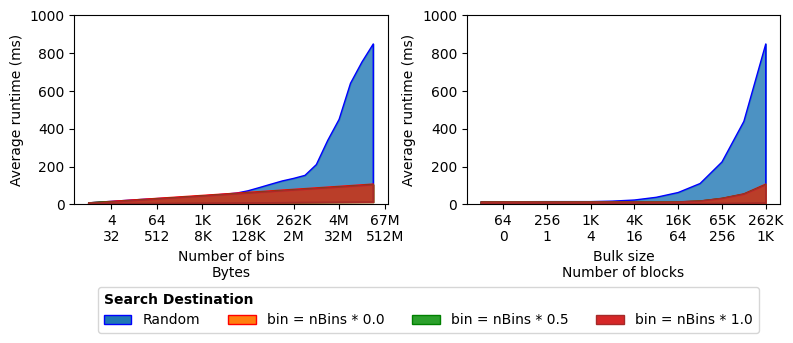

In [379]:
figname = f"../../images/gpu_binsearch_mb_variance_{int(selected_blocksize)}blocksize.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 256
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
for xi, xname in enumerate(["nbins" , "bulksize"]):
    ax = axs[xi]
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]

    X = sorted(avg[xname].unique())
    ymax = []; ymin = []
    norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    for bki, bks in enumerate(X):
        ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
        ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
        
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    fill_between_edges(ax, X, ymin, ymax, colors[0], ecolors[0], label=f"Random")
    
    for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
        arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
               & (bsbm_mean["param_3"] == dest) 
               & (bsbm_mean["blocksize"] == selected_blocksize)
              )
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]

        X = sorted(avg[xname].unique())
        ymax = []; ymin = []
        norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        for bki, bks in enumerate(X):
            ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
            ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
            
        Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        fill_between_edges(ax, X, ymin, ymax, colors[di+1], ecolors[di+1], label=f"bin = nBins * {int(dest)/4.}")

    if xname == "nbins":
        ax.set_xlabel("Number of bins\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
    else:
        ax.set_xlabel("Bulk size\nNumber of blocks")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))

    ax.set_ylabel(f"Average runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 1000)


hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

fig.tight_layout()
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.12, -.15), ncols=4)
plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

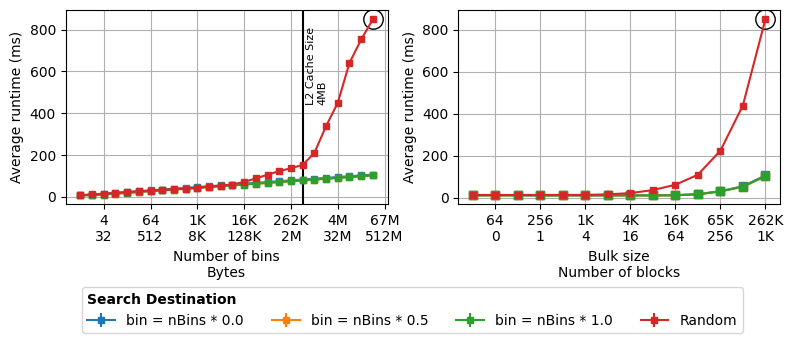

In [380]:
## figname = "../../images/gpu_binsearch_mb.pdf"

selected_size = 33554432
selected_bulksize = 32768*8
selected_blocksize = 256
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["bulksize"] == selected_bulksize) 
           & (bsbm_mean["blocksize"] == selected_blocksize)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["nbins"], 
                 avg["real_time"]  * norm,
                 yerr=std["real_time"] *norm, 
                  label=f"bin = nBins * {int(dest)/4.}", **bm_style)

selected_func = "BinarySearchGPURandom"
arg = ((bsbm_mean["func_name"] == selected_func) 
       & (bsbm_mean["bulksize"] == selected_bulksize) 
       & (bsbm_mean["blocksize"] == selected_blocksize)
      )
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["nbins"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] * norm, label=f"Random",
             **bm_style
            )


plt.plot(selected_size, 
         avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
         'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Number of bins\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])
plt.grid()

plt.axvline(x=a4000_l2_size/8, c="k")
plt.text(a4000_l2_size/8*1.2, 450, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

#############

ax = plt.subplot(122)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant")
           &  (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["nbins"] == selected_size)  
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm, 
                 marker="s",
                 # label=f"v = {int(dest)/4.}"
                )
arg = ((bsbm_mean["func_name"] == selected_func)
       & (bsbm_mean["nbins"] == selected_size)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
             yerr=std["real_time"] * norm, **bm_style, 
             # label=f"v = {int(dest)/4.}"
            )

plt.plot(selected_bulksize, 
            avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm ,
            'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Bulk size\nNumber of blocks")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
# secax = ax.secondary_xaxis('bottom')
# secax.set_xlabel('period [s]')

plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

plt.grid()
plt.tight_layout()
fig.legend(title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.1, -0.15), ncols=4)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

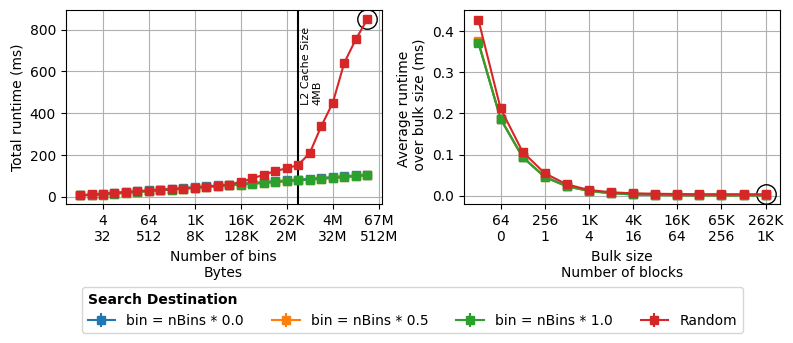

In [401]:
figname = "../../images/gpu_binsearch_mb_avg.pdf"

selected_size = 33554432
selected_bulksize = 32768*8
selected_blocksize = 256
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["bulksize"] == selected_bulksize) 
           & (bsbm_mean["blocksize"] == selected_blocksize)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["nbins"], 
                 avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm,
                 marker="s",label=f"bin = nBins * {int(dest)/4.}")

selected_func = "BinarySearchGPURandom"
arg = ((bsbm_mean["func_name"] == selected_func) 
       & (bsbm_mean["bulksize"] == selected_bulksize) 
       & (bsbm_mean["blocksize"] == selected_blocksize)
      )
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["nbins"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] * norm,
             marker="s", label=f"Random"
            )


plt.plot(selected_size, 
         avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
         'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Number of bins\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])
plt.grid()
plt.axvline(x=a4000_l2_size/8, c="k")
plt.text(a4000_l2_size/8*1.2, 450, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

#############

ax = plt.subplot(122)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant")
           &  (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["nbins"] == selected_size)  
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["bulksize"], avg["real_time"]  * norm / avg["bulksize"],
                 yerr=std["real_time"] * norm / avg["bulksize"],
                 marker="s",
                 # label=f"v = {int(dest)/4.}"
                )
arg = ((bsbm_mean["func_name"] == selected_func)
       & (bsbm_mean["nbins"] == selected_size)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["bulksize"], avg["real_time"]  * norm / avg["bulksize"],
             yerr=std["real_time"] * norm / avg["bulksize"],
             # label=f"v = {int(dest)/4.}"
                 marker="s",
             
            )

plt.plot(selected_bulksize, 
            avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm / selected_bulksize,
            **sl_style)

plt.xlabel("Bulk size\nNumber of blocks")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
# secax = ax.secondary_xaxis('bottom')
# secax.set_xlabel('period [s]')

plt.ylabel(f"Average runtime \n over bulk size ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])
# ax.set_ylim([0, 0.02])
plt.grid()

plt.tight_layout()
fig.legend(title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.1, -0.15), ncols=4)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Calibration

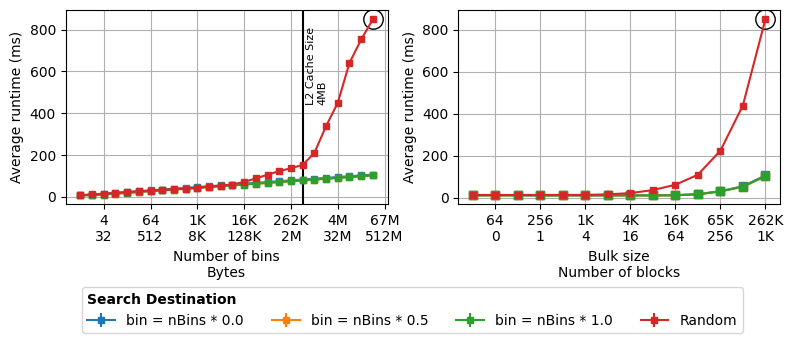

In [382]:
figname = "../../images/gpu_binsearch_mb.pdf"

selected_size = 33554432
selected_bulksize = 32768*8
selected_blocksize = 256
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["bulksize"] == selected_bulksize) 
           & (bsbm_mean["blocksize"] == selected_blocksize)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["nbins"], 
                 avg["real_time"]  * norm,
                 yerr=std["real_time"] *norm, 
                  label=f"bin = nBins * {int(dest)/4.}", **bm_style)

selected_func = "BinarySearchGPURandom"
arg = ((bsbm_mean["func_name"] == selected_func) 
       & (bsbm_mean["bulksize"] == selected_bulksize) 
       & (bsbm_mean["blocksize"] == selected_blocksize)
      )
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["nbins"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] * norm, label=f"Random",
             **bm_style
            )


plt.plot(selected_size, 
         avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
         'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Number of bins\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])
plt.grid()

plt.axvline(x=a4000_l2_size/8, c="k")
plt.text(a4000_l2_size/8*1.2, 450, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

#############

ax = plt.subplot(122)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant")
           &  (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["nbins"] == selected_size)  
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm, 
                 marker="s",
                 # label=f"v = {int(dest)/4.}"
                )
arg = ((bsbm_mean["func_name"] == selected_func)
       & (bsbm_mean["nbins"] == selected_size)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
             yerr=std["real_time"] * norm, **bm_style, 
             # label=f"v = {int(dest)/4.}"
            )

plt.plot(selected_bulksize, 
            avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm ,
            'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Bulk size\nNumber of blocks")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
# secax = ax.secondary_xaxis('bottom')
# secax.set_xlabel('period [s]')

plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

plt.grid()
plt.tight_layout()
fig.legend(title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.1, -0.15), ncols=4)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Validation

In [383]:
validation_results = "das6-gpu/validation" 
validation_df = pd.read_csv(validation_results)
validation_df["nvals"] =  validation_df["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
validation_df["distribution"] = validation_df["input"].apply(lambda s: s.split("_")[1])
convert_to_type(validation_df, "tfindbin", np.float64)
convert_to_type(validation_df, "tfill", np.float64)
convert_to_type(validation_df, "tstats", np.float64)
convert_to_type(validation_df, "edges", np.bool_)
del validation_df["input"]
validation_df

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CUDA_HIST,A4000,86,10,8192,False,256,0.0,0.0,0.0,1.525065,5.000000e+07,normal-0.4-0.1
1,0,CUDA_HIST,A4000,86,10,8192,False,256,0.0,0.0,0.0,2.155579,1.000000e+08,normal-0.4-0.1
2,0,CUDA_HIST,A4000,86,10,8192,False,256,0.0,0.0,0.0,8.711180,5.000000e+08,normal-0.4-0.1
3,0,CUDA_HIST,A4000,86,10,8192,False,256,0.0,0.0,0.0,15.100885,1.000000e+09,normal-0.4-0.1
4,0,CUDA_HIST,A4000,86,10,8192,True,256,0.0,0.0,0.0,1.540224,5.000000e+07,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,4,CUDA_HIST,A4000,86,10000000,134217728,False,256,0.0,0.0,0.0,9.704277,1.000000e+09,uniform
5756,4,CUDA_HIST,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,0.777054,5.000000e+07,uniform
5757,4,CUDA_HIST,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,1.378382,1.000000e+08,uniform
5758,4,CUDA_HIST,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,5.136527,5.000000e+08,uniform


# Add Bin Content

## Design

In [384]:
filename = "../microbenchmarks/das6/addbincontent_gpu.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
abcbm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(abcbm_df, "real_time", np.float64)
abcbm_df["func_name"] = abcbm_df["name"].apply(lambda s: s.split("/")[0][3:])    
abcbm_df["time_factor"] = abcbm_df["time_unit"].apply(convert_unit)
del (
    abcbm_df["family_index"], abcbm_df["per_family_instance_index"],  
    abcbm_df["run_name"], abcbm_df["threads"], abcbm_df["run_type"], 
    abcbm_df["aggregate_unit"], abcbm_df["repetition_index"],  abcbm_df["error_occurred"],
    abcbm_df["error_message"]
)
abcbm_df["time_factor"] = abcbm_df["time_unit"].apply(convert_unit)
abcbm_df

,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,global,nbins,numblocks,random,func_name,time_factor
0,BM_HistogramGPU/8/32/32/0/1/manual_time_mean,10.0,mean,3,45.226667,0.054556,ms,32.0,32.0,1.0,1.0,1.0,0.0,HistogramGPU,1000.0
1,BM_HistogramGPU/8/32/32/0/1/manual_time_median,10.0,median,3,45.129143,0.054402,ms,32.0,32.0,1.0,1.0,1.0,0.0,HistogramGPU,1000.0
2,BM_HistogramGPU/8/32/32/0/1/manual_time_stddev,0.0,stddev,3,0.304518,0.000414,ms,0.0,0.0,0.0,0.0,0.0,0.0,HistogramGPU,1000.0
3,BM_HistogramGPU/8/32/32/0/1/manual_time_cv,0.0,cv,3,0.006733,0.007582,ms,0.0,0.0,0.0,0.0,0.0,NaN,HistogramGPU,1000.0
4,BM_HistogramGPU/16/32/32/0/1/manual_time_mean,10.0,mean,3,45.470477,0.054713,ms,32.0,32.0,1.0,2.0,1.0,0.0,HistogramGPU,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32755,BM_HistogramGPU/134217728/262144/1024/1/0/manu...,3.0,NaN,0,0.000000,0.000000,ms,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU,1000.0
32756,BM_HistogramGPU/134217728/262144/1024/1/0/manu...,3.0,NaN,0,0.000000,0.000000,ms,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU,1000.0
32757,BM_HistogramGPU/268435456/262144/1024/1/0/manu...,3.0,NaN,0,0.000000,0.000000,ms,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU,1000.0
32758,BM_HistogramGPU/268435456/262144/1024/1/0/manu...,3.0,NaN,0,0.000000,0.000000,ms,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU,1000.0


In [385]:
unique_bulksize = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["bulksize"].unique_non_nan()
unique_blocksize = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["blocksize"].unique_non_nan()
unique_numblocks = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["numblocks"].unique_non_nan()
unique_nbins = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["nbins"].unique_non_nan()
unique_global = [True, False]
unique_random = [True, False]
unique_bulksize, unique_blocksize, unique_numblocks, unique_nbins, unique_global, unique_random

(array([3.20000e+01, 6.40000e+01, 1.28000e+02, 2.56000e+02, 5.12000e+02,
        1.02400e+03, 2.04800e+03, 4.09600e+03, 8.19200e+03, 1.63840e+04,
        3.27680e+04, 6.55360e+04, 1.31072e+05, 2.62144e+05]),
 array([  32.,   64.,  128.,  256.,  512., 1024.]),
 array([1.000e+00, 2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01,
        6.400e+01, 1.280e+02, 2.560e+02, 5.120e+02, 1.024e+03, 2.048e+03,
        4.096e+03, 8.192e+03]),
 array([1.0000000e+00, 2.0000000e+00, 4.0000000e+00, 8.0000000e+00,
        1.6000000e+01, 3.2000000e+01, 6.4000000e+01, 1.2800000e+02,
        2.5600000e+02, 5.1200000e+02, 1.0240000e+03, 2.0480000e+03,
        4.0960000e+03, 8.1920000e+03, 1.6384000e+04, 3.2768000e+04,
        6.5536000e+04, 1.3107200e+05, 2.6214400e+05, 5.2428800e+05,
        1.0485760e+06, 2.0971520e+06, 4.1943040e+06, 8.3886080e+06,
        1.6777216e+07, 3.3554432e+07]),
 [True, False],
 [True, False])

In [386]:
n_param = len(abcbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        abcbm_df[f"param_{i}"] = abcbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0] if i+1 < len(s.split("_/")) else None)
    else:
        abcbm_df[f"param_{i}"] = abcbm_df["name"].apply(lambda s: s.split("/")[i+1] if i+1 < len(s.split("/")) else None)

convert_to_type(abcbm_df, "bulksize", np.int64)
convert_to_type(abcbm_df, "blocksize", np.int64)
convert_to_type(abcbm_df, "numblocks", np.int64)
convert_to_type(abcbm_df, "nbins", np.int64)
convert_to_type(abcbm_df, "random", np.bool_)
convert_to_type(abcbm_df, "global", np.bool_)
abcbm_mean = (abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"].reset_index())
abcbm_std = (abcbm_df.loc[abcbm_df["aggregate_name"] == "stddev"].reset_index())
abcbm_mean

,index,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,...,numblocks,random,func_name,time_factor,param_0,param_1,param_2,param_3,param_4,param_5
0,0,BM_HistogramGPU/8/32/32/0/1/manual_time_mean,10.0,mean,3,45.226667,0.054556,ms,32.0,32.0,...,1.0,False,HistogramGPU,1000.0,8,32,32,0,1,None
1,4,BM_HistogramGPU/16/32/32/0/1/manual_time_mean,10.0,mean,3,45.470477,0.054713,ms,32.0,32.0,...,1.0,False,HistogramGPU,1000.0,16,32,32,0,1,None
2,8,BM_HistogramGPU/32/32/32/0/1/manual_time_mean,10.0,mean,3,45.215289,0.054320,ms,32.0,32.0,...,1.0,False,HistogramGPU,1000.0,32,32,32,0,1,None
3,12,BM_HistogramGPU/64/32/32/0/1/manual_time_mean,10.0,mean,3,45.525334,0.054472,ms,32.0,32.0,...,1.0,False,HistogramGPU,1000.0,64,32,32,0,1,None
4,16,BM_HistogramGPU/128/32/32/0/1/manual_time_mean,10.0,mean,3,45.589334,0.054625,ms,32.0,32.0,...,1.0,False,HistogramGPU,1000.0,128,32,32,0,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6547,32701,BM_HistogramGPU/2048/262144/1024/1/0/manual_ti...,10.0,mean,3,529.066662,0.600510,ms,1024.0,262144.0,...,256.0,True,HistogramGPU,1000.0,2048,262144,1024,1,0,None
6548,32705,BM_HistogramGPU/4096/262144/1024/1/0/manual_ti...,10.0,mean,3,429.568003,0.469550,ms,1024.0,262144.0,...,256.0,True,HistogramGPU,1000.0,4096,262144,1024,1,0,None
6549,32709,BM_HistogramGPU/8192/262144/1024/1/0/manual_ti...,10.0,mean,3,391.680002,0.431566,ms,1024.0,262144.0,...,256.0,True,HistogramGPU,1000.0,8192,262144,1024,1,0,None
6550,32713,BM_HistogramGPU/16384/262144/1024/1/0/manual_t...,10.0,mean,3,517.120004,0.587979,ms,1024.0,262144.0,...,256.0,True,HistogramGPU,1000.0,16384,262144,1024,1,0,None


<function matplotlib.pyplot.show(close=None, block=None)>

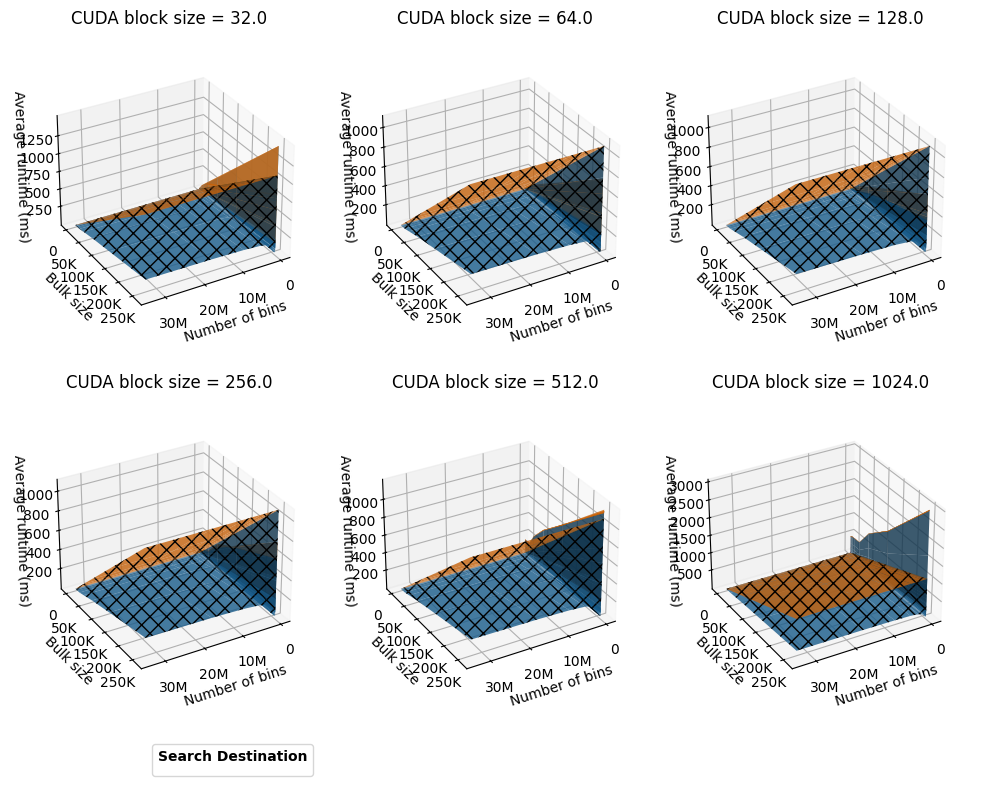

In [387]:
figname = "../../images/gpu_addbincontent_mb_3d.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 1024
selected_val = 0
unit = "ms"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={"projection": "3d"}, figsize=(10, 10))
for bi, bs in enumerate(unique_blocksize):
    ax = axs[int(bi/3), bi%3]
    # ax.grid()
    for hti, htglbl in enumerate(unique_global):
        for di, rndmdest in enumerate([True, False]):
            ax.set_title(f"CUDA block size = {bs}")
            arg = ((abcbm_mean["random"] == rndmdest) 
                   & (abcbm_mean["blocksize"] == bs)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
            X = avg["nbins"].unique()
            Y = avg["bulksize"].unique() # bulksize
            Z = avg["real_time"] * unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                             # yerr=std["real_time"] * unit_to_unit_factor(abcbm_std["time_unit"].values[0], unit) / rep, 
                            alpha=0.8,
                            color=colors[0] if rndmdest else colors[1], 
                            hatch="xx" if htglbl else "", 
                            label=f"")
    

    ax.set_xlabel("Number of bins")
    # ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel("Bulk size")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_zlabel(f"Average runtime ({unit})")
    # ax.set_yscale("log", base=2)
    # ax.set_zlim(3, 10)
    ax.zaxis.labelpad=-0.7 # <- change the value here
    ax.view_init(elev=30, azim=60, roll=0)
    ax.set_box_aspect(aspect=None, zoom=0.83)

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

# plt.savefig(figname, format="pdf", bbox_inches='tight')
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show

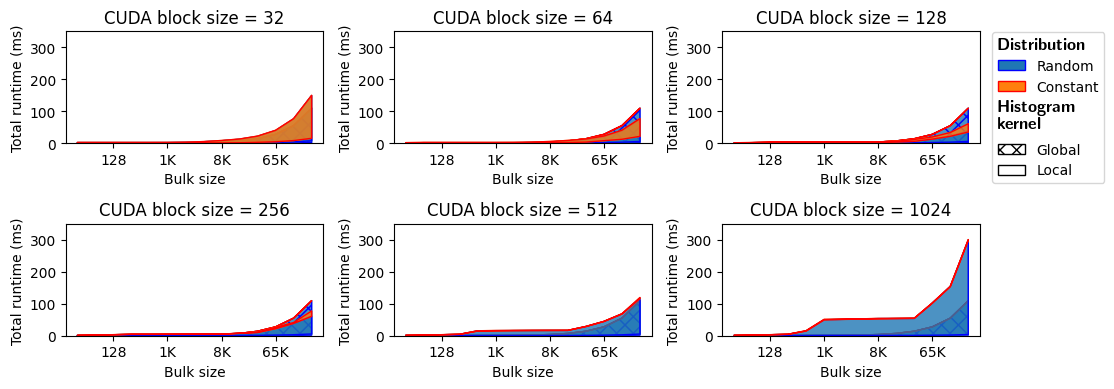

In [388]:
figname = "../../images/gpu_addbincontent_mb_variance.pdf"
selected_blocksize = 256
selected_bulksize = 32768
selected_nbins = 33554432
# selected_random = True
# selected_global = False
unit = "ms"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))
for bi, bs in enumerate(unique_blocksize):
    ax = axs[int(bi/3), bi%3]
    # ax.grid()
    for hti, htglbl in enumerate(unique_global):
        for di, rndmdest in enumerate([True, False]):
            ax.set_title(f"CUDA block size = {int(bs)}")
            arg = ((abcbm_mean["blocksize"] == bs)
                   # & (abcbm_mean["bulksize"] == selected_bulksize) 
                   # & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
    
            xname = "bulksize"
            X = sorted(avg[xname].unique())
            ymax = []; ymin = []
            norm =  unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            for bki, bks in enumerate(X):
                ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm / rep)
                ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm / rep)
                
            Z = avg["real_time"] * unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            fill_between_edges(ax, X, ymin, ymax, 
                               facecolor=colors[0] if rndmdest else colors[1], 
                               edgecolor="b" if rndmdest else "r", 
                                label="",
                                hatch="xx" if htglbl else "", 
                              )
            
    ax.set_xlabel(f'{"Number of bins" if xname == "nbins" else "Bulk size"}')
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 350)
    
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], edgecolor=ecolors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], edgecolor=ecolors[1], label=f"Constant"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0,  hatch="xx" , edgecolor="k", facecolor="white", label=f"Global"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor="white", edgecolor="k", label=f"Local"))

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.51), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

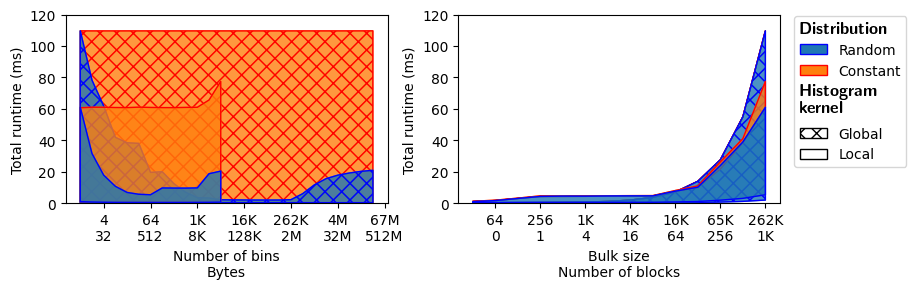

In [389]:
figname = "../../images/gpu_addbincontent_mb_variance_256blocksize.pdf"
selected_blocksize = 256
selected_bulksize = 32768
selected_nbins = 33554432
# selected_random = True
# selected_global = False
unit = "ms"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
for xi, xname in enumerate(["nbins" , "bulksize"]):
    ax = axs[xi]
    # ax.grid()
    for hti, htglbl in enumerate(unique_global):
        for di, rndmdest in enumerate([False, True]):
            # ax.set_title(f"Number of bins = {int(selected_nbins)}")
            arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                   # & (abcbm_mean["bulksize"] == selected_bulksize) 
                   # & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
    
            X = sorted(avg[xname].unique())
            ymax = []; ymin = []
            norm =  unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            for bki, bks in enumerate(X):
                ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm / rep)
                ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm / rep)
                
            Z = avg["real_time"] * unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            fill_between_edges(ax, X, ymin, ymax, 
                               facecolor=colors[0] if rndmdest else colors[1], 
                               edgecolor="b" if rndmdest else "r", 
                                label="",
                                hatch="xx" if htglbl else "", 
                              )
    if xname == "nbins":
        ax.set_xlabel(f"Number of bins\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
    else:
        ax.set_xlabel("Bulk size\nNumber of blocks")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 120)
###
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], edgecolor=ecolors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], edgecolor=ecolors[1], label=f"Constant"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0,  hatch="xx" , edgecolor="k", facecolor="white", label=f"Global"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor="white", edgecolor="k", label=f"Local"))

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.4), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

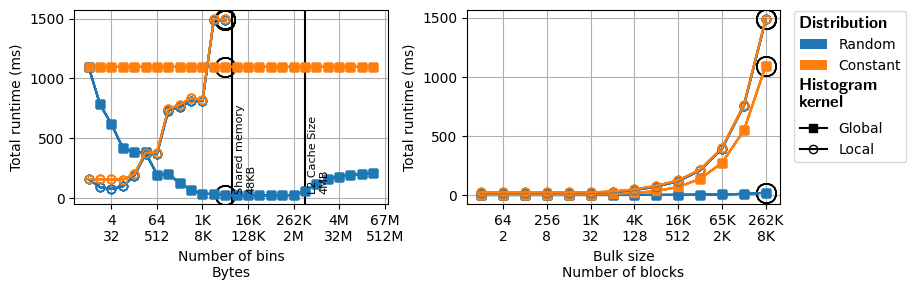

In [390]:
figname = "../../images/gpu_addbincontent_mb.pdf"

selected_nbins = 4096
selected_bulksize = 32768*8
selected_blocksize = 32
selected_val = 0
unit = "ms"
rep  = abcbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

for bi, bs in enumerate(unique_blocksize):
    for hti, htglbl in enumerate(unique_global):
        for di, rndmdest in enumerate([True, False]):
            arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                   & (abcbm_mean["bulksize"] == selected_bulksize) 
                   # & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
            c = colors[0] if rndmdest else colors[1]
            ax.errorbar(avg["nbins"], 
                         avg["real_time"]  * norm,
                         yerr=std["real_time"] *norm, 
                         color=c,
                         marker="s" if htglbl else "o",
                         markerfacecolor=c if htglbl else "none"
                         # label=f"{'Global' if dest else 'Local'}", 
                         # **bm_style
                        )
            plt.plot(selected_nbins, 
                     avg.loc[avg["nbins"] == selected_nbins]["real_time"] * norm,
                     'ok', ms=14, markerfacecolor="None",)

plt.axvline(x=a4000_maxsmem/8, c="k")
plt.text(a4000_maxsmem/8*1.2, 50, f'Shared memory\n{human_readable(a4000_maxsmem, bytes=True)}B',rotation=90, fontsize=8)
plt.axvline(x=a4000_l2_size/8, c="k")
plt.text(a4000_l2_size/8*1.2, 50, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

plt.xlabel("Number of bins\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])
plt.grid()

#############

ax = plt.subplot(122)
for bi, bs in enumerate(unique_blocksize):
    for hti, htglbl in enumerate([True, False]):
        for di, rndmdest in enumerate([True, False]):
            arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                   # & (abcbm_mean["bulksize"] == selected_bulksize) 
                   & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
            c = colors[0] if rndmdest else colors[1]
            ax.errorbar(avg["bulksize"], 
                         avg["real_time"]  * norm,
                         yerr=std["real_time"] *norm,
                         color=c,
                         marker="s" if htglbl else "o",
                         markerfacecolor=c if htglbl else "none"
                         # label=f"{'Global' if dest else 'Local'}", 
                         # **bm_style
                        )
            plt.plot(selected_bulksize, 
                     avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm,
                     'ok', ms=14, markerfacecolor="None",)
            
# plt.plot(selected_size, 
#          avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
#          'ok', ms=14, markerfacecolor="None",)
plt.xlabel("Bulk size\nNumber of blocks")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

# plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], label=f"Constant"))
ax.plot(0, 0, color="k", marker="s", label=f"Global")
ax.plot(0, 0, color="k", marker="o", markerfacecolor="none", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

plt.grid()
fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.42), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

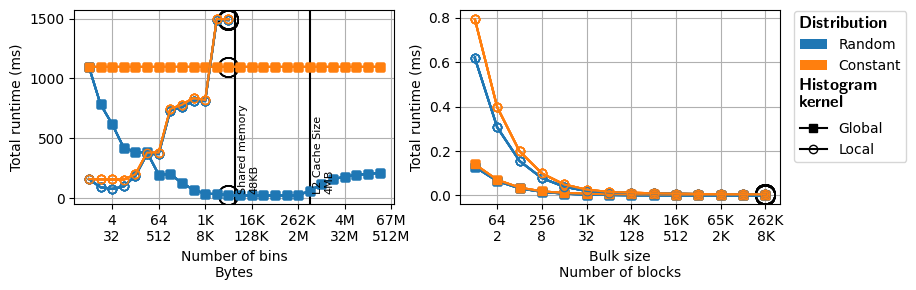

In [391]:
figname = "../../images/gpu_addbincontent_mb.pdf"

selected_nbins = 4096
selected_bulksize = 32768*8
selected_blocksize = 32
selected_val = 0
unit = "ms"
rep  = abcbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

for bi, bs in enumerate(unique_blocksize):
    for hti, htglbl in enumerate(unique_global):
        for di, rndmdest in enumerate([True, False]):
            arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                   & (abcbm_mean["bulksize"] == selected_bulksize) 
                   # & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
            c = colors[0] if rndmdest else colors[1]
            ax.errorbar(avg["nbins"], 
                         avg["real_time"]  * norm,
                         yerr=std["real_time"] *norm, 
                         color=c,
                         marker="s" if htglbl else "o",
                         markerfacecolor=c if htglbl else "none"
                         # label=f"{'Global' if dest else 'Local'}", 
                         # **bm_style
                        )
            plt.plot(selected_nbins, 
                     avg.loc[avg["nbins"] == selected_nbins]["real_time"] * norm,
                     'ok', ms=14, markerfacecolor="None",)

plt.axvline(x=a4000_maxsmem/8, c="k")
plt.text(a4000_maxsmem/8*1.2, 50, f'Shared memory\n{human_readable(a4000_maxsmem, bytes=True)}B',rotation=90, fontsize=8)
plt.axvline(x=a4000_l2_size/8, c="k")
plt.text(a4000_l2_size/8*1.2, 50, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

plt.xlabel("Number of bins\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])
plt.grid()

#############

ax = plt.subplot(122)
for bi, bs in enumerate(unique_blocksize):
    for hti, htglbl in enumerate([True, False]):
        for di, rndmdest in enumerate([True, False]):
            arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                   # & (abcbm_mean["bulksize"] == selected_bulksize) 
                   & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
            c = colors[0] if rndmdest else colors[1]
            ax.errorbar(avg["bulksize"], 
                         avg["real_time"]  * norm /avg["bulksize"],
                         yerr=std["real_time"] *norm/avg["bulksize"],
                         color=c,
                         marker="s" if htglbl else "o",
                         markerfacecolor=c if htglbl else "none"
                         # label=f"{'Global' if dest else 'Local'}", 
                         # **bm_style
                        )
            plt.plot(selected_bulksize, 
                     avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm / selected_bulksize,
                     'ok', ms=14, markerfacecolor="None",)
            
# plt.plot(selected_size, 
#          avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
#          'ok', ms=14, markerfacecolor="None",)
plt.xlabel("Bulk size\nNumber of blocks")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

# plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], label=f"Constant"))
ax.plot(0, 0, color="k", marker="s", label=f"Global")
ax.plot(0, 0, color="k", marker="o", markerfacecolor="none", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

plt.grid()
fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.42), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

# Update Stats

## Design

In [392]:
filename = "../microbenchmarks/das6/transformreduce_gpu.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
trbm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(trbm_df, "real_time", np.float64)
trbm_df["func_name"] = trbm_df["name"].apply(lambda s: s.split("/")[0][3:])    
trbm_df["time_factor"] = trbm_df["time_unit"].apply(convert_unit)
del trbm_df["family_index"], trbm_df["per_family_instance_index"],  trbm_df["run_name"], trbm_df["threads"], trbm_df["run_type"], trbm_df["aggregate_unit"]
trbm_df["time_factor"] = trbm_df["time_unit"].apply(convert_unit)

trbm_df.head(10)

,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,numblocks,numthreads,func_name,time_factor
0,BM_TransformReduceGPU/32/32/manual_time_mean,1000.0,mean,3,4250.965436,4.252074,ms,32.0,32.0,1.0,16.0,TransformReduceGPU,1000.0
1,BM_TransformReduceGPU/32/32/manual_time_median,1000.0,median,3,4251.647949,4.253206,ms,32.0,32.0,1.0,16.0,TransformReduceGPU,1000.0
2,BM_TransformReduceGPU/32/32/manual_time_stddev,0.0,stddev,3,4.138459,0.009902,ms,0.0,0.0,0.0,0.0,TransformReduceGPU,1000.0
3,BM_TransformReduceGPU/32/32/manual_time_cv,0.0,cv,3,0.000974,0.002329,ms,0.0,0.0,0.0,0.0,TransformReduceGPU,1000.0
4,BM_TransformReduceGPU/64/32/manual_time_mean,1000.0,mean,3,4257.429282,4.251126,ms,32.0,64.0,1.0,32.0,TransformReduceGPU,1000.0
5,BM_TransformReduceGPU/64/32/manual_time_median,1000.0,median,3,4255.743980,4.252334,ms,32.0,64.0,1.0,32.0,TransformReduceGPU,1000.0
6,BM_TransformReduceGPU/64/32/manual_time_stddev,0.0,stddev,3,2.974535,0.002643,ms,0.0,0.0,0.0,0.0,TransformReduceGPU,1000.0
7,BM_TransformReduceGPU/64/32/manual_time_cv,0.0,cv,3,0.000699,0.000622,ms,0.0,0.0,0.0,0.0,TransformReduceGPU,1000.0
8,BM_TransformReduceGPU/128/32/manual_time_mean,1000.0,mean,3,4265.301228,4.264738,ms,32.0,128.0,2.0,32.0,TransformReduceGPU,1000.0
9,BM_TransformReduceGPU/128/32/manual_time_median,1000.0,median,3,4262.911797,4.262994,ms,32.0,128.0,2.0,32.0,TransformReduceGPU,1000.0


In [393]:
n_param = len(trbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        trbm_df[f"param_{i}"] = trbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0] if i+1 < len(s.split("_/")) else None)
    else:
        trbm_df[f"param_{i}"] = trbm_df["name"].apply(lambda s: s.split("/")[i+1] if i+1 < len(s.split("/")) else None)

convert_to_type(trbm_df, "numthreads", np.int64)
convert_to_type(trbm_df, "numblocks", np.int64)
convert_to_type(trbm_df, "blocksize", np.int64)

trbm_mean = trbm_df.loc[trbm_df["aggregate_name"] == "mean"].reset_index()
trbm_std = trbm_df.loc[trbm_df["aggregate_name"] == "stddev"].reset_index()
# convert_to_type(
trbm_mean

,index,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,numblocks,numthreads,func_name,time_factor,param_0,param_1,param_2
0,0,BM_TransformReduceGPU/32/32/manual_time_mean,1000.0,mean,3,4250.965436,4.252074,ms,32,32.0,1,16,TransformReduceGPU,1000.0,32,32,None
1,4,BM_TransformReduceGPU/64/32/manual_time_mean,1000.0,mean,3,4257.429282,4.251126,ms,32,64.0,1,32,TransformReduceGPU,1000.0,64,32,None
2,8,BM_TransformReduceGPU/128/32/manual_time_mean,1000.0,mean,3,4265.301228,4.264738,ms,32,128.0,2,32,TransformReduceGPU,1000.0,128,32,None
3,12,BM_TransformReduceGPU/256/32/manual_time_mean,1000.0,mean,3,4261.205196,4.259531,ms,32,256.0,4,32,TransformReduceGPU,1000.0,256,32,None
4,16,BM_TransformReduceGPU/512/32/manual_time_mean,1000.0,mean,3,4272.810618,4.272519,ms,32,512.0,8,32,TransformReduceGPU,1000.0,512,32,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,316,BM_TransformReduceGPU/16384/1024/manual_time_mean,1000.0,mean,3,9116.330783,9.114867,ms,1024,16384.0,8,1024,TransformReduceGPU,1000.0,16384,1024,None
80,320,BM_TransformReduceGPU/32768/1024/manual_time_mean,1000.0,mean,3,9126.570702,9.133675,ms,1024,32768.0,16,1024,TransformReduceGPU,1000.0,32768,1024,None
81,324,BM_TransformReduceGPU/65536/1024/manual_time_mean,1000.0,mean,3,9151.146889,9.168313,ms,1024,65536.0,32,1024,TransformReduceGPU,1000.0,65536,1024,None
82,328,BM_TransformReduceGPU/131072/1024/manual_time_...,1000.0,mean,3,16137.216568,16.183405,ms,1024,131072.0,64,1024,TransformReduceGPU,1000.0,131072,1024,None


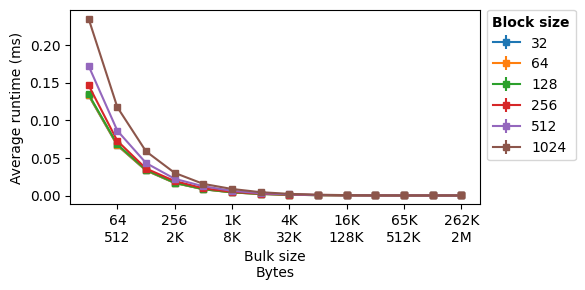

In [394]:
average = True
figname = f"../../images/gpu_updatestats_mb{('_avg' if average else '')}.pdf"

selected_bulksize = 32768*8
selected_blocksize = 256
unit = "ms"
rep  = trbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(trbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

for bsi, bs in enumerate(trbm_mean["blocksize"].unique()):
    arg = (trbm_mean["blocksize"] == bs)
    avg = trbm_mean.loc[arg]
    std = trbm_std.loc[arg]
    plt.errorbar(avg["bulksize"], 
                 avg["real_time"]  * norm / (avg["bulksize"] if average else 1),
                 yerr=std["real_time"] * norm / (avg["bulksize"] if average else 1),
                 label=f"{bs}", **bm_style)

# plt.plot(selected_size, 
#          avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
#          'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Bulk size\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"{('Average' if average else 'Total')} runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

plt.tight_layout()
fig.legend(title="Block size",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='center left', bbox_to_anchor=(0.97, 0.7), ncols=1)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Calibration

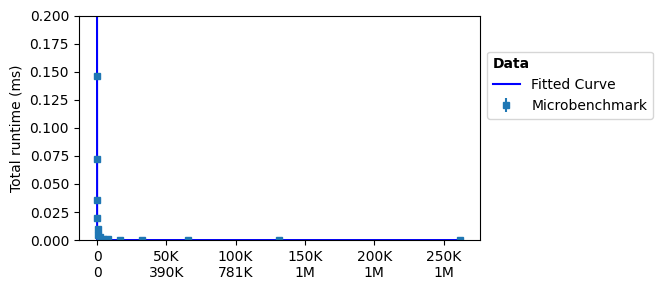

In [395]:
figname = "../../images/gpu_updatestats_calib.pdf"

# def T_gpu_usb(bulksize, a, b, c):
    # return 1/(a*bulksize+b) + c
    # return a*bulksize+b
    # return a * np.log(b * bulksize) + c
    # return a * np.exp(-b * bulksize) + c
    
selected_bulksize = 32768*8
selected_blocksize = 256
unit = "ms"
rep  = trbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(trbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

# microbenchmark data
arg = (trbm_mean["blocksize"] == selected_blocksize) 
avg = trbm_mean.loc[arg] 
std = trbm_std.loc[arg]
plt.errorbar(avg["bulksize"], 
             avg["real_time"]  * norm / avg["bulksize"],
             yerr=std["real_time"] * norm / avg["bulksize"],
             label=f"Microbenchmark", ls="", **bm_style)

# fit line
# x = np.linspace(0, pow(2, 18)+1024, 100000)
# popt, pcov = scipy.optimize.curve_fit(T_gpu_usb, avg["bulksize"], 
#                                       avg["real_time"]  * norm / avg["bulksize"], 
#                                       # p0=[6784,24,0], 
#                                       # method='trf',
#                                       maxfev=100000)
# plt.plot(x, T_gpu_usb(x, *popt), 'r-', label="Fitted Curve")
# print(popt)


# plt.plot(x, T_gpu_usb(x, 6000, 24, 0), 'b-', label="Fitted Curve")
plt.plot(x, T_gpu_usb(x, avg["real_time"].mean()  * norm, 24, 0), 'b-', label="Fitted Curve")
# plt.plot(x, np.repeat(avg["real_time"].mean() * norm, len(x)), 'b-', label="Fitted Curve")

# plt.xlabel("Bulk size\nBytes")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.yscale("log", base=2)
plt.ylim([0, 0.2])

plt.tight_layout()
fig.legend(title="Data",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='center left', bbox_to_anchor=(0.97, 0.7), ncols=1)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

In [396]:
avg["real_time"].mean()

6784.853344871885

In [397]:
avg["bulksize"]

42        32.0
43        64.0
44       128.0
45       256.0
46       512.0
47      1024.0
48      2048.0
49      4096.0
50      8192.0
51     16384.0
52     32768.0
53     65536.0
54    131072.0
55    262144.0
Name: bulksize, dtype: float64

In [398]:
unique_distributions

array(['normal-0.4-0.1', 'normal-0.7-0.01'], dtype=object)

## Validation

KeyError: 'normal-0.4-0.1'

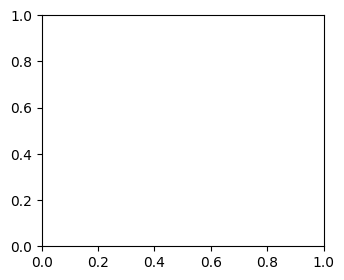

In [399]:
figname="../../images/updatestats_validation_das6_gpu.pdf"

selected_env = "CUDA" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(unique_distributions)
selected_edges = False
pred_color ="k"

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, selected_edges
    avg = gp_vd.mean().loc[arg]
    std = gp_vd.std().loc[arg]
    
    p = ax.errorbar(unique_nbins, avg["tstats"], 
                     yerr=std["tstats"], 
                     marker="s", ecolor="k", markersize=5,
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                 label=f"{map_distr_name(distr)}".title()
                )
    # Legend Labels
    # ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
    #                              facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
print(distr)
pred = np.repeat(T_updatestats * selected_nvals * unit_to_unit_factor("ns", "s"), len(unique_nbins))
ax.errorbar(unique_nbins, 
            pred, 
            c=pred_color,
            marker="s", markerfacecolor="none", ls="--", markersize=7,
)
observ = avg["tstats"].values
print("MAE:", mae(pred, observ))
print("R2:", r2(pred, observ) * 100)
    
plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, 50])
plt.ylabel("Average runtime (s)")

ax = plt.subplot(122)
for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, unique_nvals, selected_nbins, selected_bulksize, selected_edges
    avg = gp_vd.mean().loc[arg]
    std = gp_vd.std().loc[arg]
    
    p = ax.errorbar(unique_nvals, avg["tstats"], 
                     yerr=std["tstats"], 
                     marker="s", ecolor="k", markersize=5,
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                 label=f"{map_distr_name(distr)}".title()
                )
    # Legend Labels
    # ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
    #                              facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
print(distr)
pred = T_updatestats[0] * unique_nvals * unit_to_unit_factor("ns", "s")
ax.errorbar(unique_nvals, 
            pred, 
            c=pred_color,
            marker="s", markerfacecolor="none", ls="--", markersize=7,
            label="Prediction"
)
observ = avg["tstats"].values
print("MAE:", mae(pred, observ))
print("R2:", r2(pred, observ) * 100)
    
plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylim([0, 50])

plt.legend(title="Distribution", loc='center left', bbox_to_anchor=(1, 0.7),  alignment="left", title_fontproperties={'weight':'bold'})

plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

# Total Validation

In [ ]:
figname ="../../images/gpu_total_vs_inner_das6.pdf"
selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distributions
edg = True
unit = "s"

fig = plt.figure(figsize=(8, 5))

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi*3+1)
    
    for distr in unique_distributions:
        # Total
        arg = selected_env, selected_gpu, distr, selected_nvals, selected_nbins, unique_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_bulksize, ttotal_avg, yerr=ttotal_std, **vd_style, 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            tapi =  gp_api.mean().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            p = plt.errorbar(unique_bulksize, 
                             (tkernels + tmemop + tapi) * unit_to_unit_factor("ns", unit), 
                             **sum_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
        
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Bulk size")
        
    plt.ylim([0,20])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+2)
    
    for distr in unique_distributions:
        # Total
        arg = selected_env, selected_gpu, distr, unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_nvals, ttotal_avg, yerr=ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            tapi =  gp_api.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            p = plt.errorbar(unique_nvals, 
                             (tkernels + tmemop + tapi) * unit_to_unit_factor("ns", unit), 
                             **sum_style, color=p[0].get_color(),                             )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of events")
        
    plt.ylim([0,20])
    plt.title(f"{'Explicit' if edg else 'Implicit'} edges")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+3)
    
    # Legend Labels
    ax.plot(0,0, label="Measured total runtime", c="k", **vd_style)
    plt.plot(0,0, label="Sum of measured components", c="k", **sum_style)
    
    for distr in unique_distributions:
        arg = selected_env, selected_gpu, distr, selected_nvals, unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_nbins, ttotal_avg, yerr=ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
            tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
            tapi =  gp_api.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"] 
            p = plt.errorbar(unique_nbins, 
                             (tkernels + tmemop + tapi) * unit_to_unit_factor("ns", unit), 
                             **sum_style, color=p[0].get_color(), 
                            )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))


    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of bins")

    plt.ylim([0,20])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.15), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

fig.supylabel('Average runtime (s)')

plt.tight_layout()
# plt.savefig(figname, format="pdf", bbox_inches='tight')

In [ ]:
figname ="../../images/gpu_validation_das6.pdf"
selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distributions
edg = True

fig = plt.figure(figsize=(8, 5))

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi*3+1)
    
    for distr in unique_distributions:
        arg = selected_env, selected_gpu, distr, selected_nvals, selected_nbins, unique_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_bulksize, ttotal_avg, yerr=ttotal_std, **vd_style)
    
        # Predicition in nanoseconds!
        # subsize = get_subsize(distr, selected_nbins)
        # tfill_pred = T_fill(selected_nbins, subsize)
        # tfindbin_pred = T_findbin(edg, selected_nbins, subsize)
        # tusb_pred = T_updatestats
        # print("tfill_pred:", tfill_pred)
        # print("tfindbin_pred:", tfindbin_pred)
        # print("tusb_pred:", tusb_pred)
        # p = plt.errorbar(unique_bulksize, 
        #                  np.repeat((tfill_pred + tusb_pred + tfindbin_pred) * selected_nvals * unit_to_unit_factor("ns", "s"), 
        #                            len(unique_bulksize)), **pred_style)
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
        
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Bulk size")
        
    plt.ylim([0,20])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+2)
    
    for distr in unique_distributions:
        arg = selected_env, selected_gpu, distr, unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_nvals, ttotal_avg, yerr=ttotal_std, **vd_style)
    
        # In nanoseconds!
        # subsize = get_subsize(distr, selected_nbins)
        # tfill_pred = T_fill(selected_nbins, subsize)
        # tfindbin_pred = T_findbin(edg, selected_nbins, subsize)
        # tusb_pred = T_updatestats[0]
        # print("tfill_pred:", tfill_pred)
        # print("tfindbin_pred:", tfindbin_pred)
        # print("tusb_pred:", tusb_pred)
        # p = plt.errorbar(unique_nvals, 
        #                 (tfill_pred + tusb_pred + tfindbin_pred) * unique_nvals * unit_to_unit_factor("ns", "s"),**pred_style)
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of events")
        
    plt.ylim([0,20])
    plt.title(f"{'Explicit' if edg else 'Implicit'} edges")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+3)
    
    # Legend Labels
    ax.plot(0,0, label="Measured total runtime", c="k", **vd_style)
    plt.plot(0,0, label="Model prediction", c="k", **pred_style)
    
    for distr in unique_distributions:
        arg = selected_env, selected_gpu, distr, selected_nvals, unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_nbins, ttotal_avg, yerr=ttotal_std, **vd_style)
                    
    
        # In nanoseconds!
        # subsize = get_subsize(distr, unique_nbins)
        # tfill_pred = T_fill(unique_nbins, subsize)
        # tfindbin_pred = T_findbin(edg, unique_nbins, subsize)
        # tusb_pred = T_updatestats[0]
        # print("tfill_pred:", tfill_pred)
        # print("tfindbin_pred:", tfindbin_pred)
        # print("tusb_pred:", tusb_pred)
        # p = plt.errorbar(unique_nbins, 
        #                  (tfill_pred + tusb_pred + tfindbin_pred) * selected_nvals * unit_to_unit_factor("ns", "s"),**pred_style)
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

    # plt.plot(selected_nbins, 
    #         avg.loc[ttotal_avg["nbins"] == selected_nbins]["ttotal"],
    #         **sl_style)

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of bins")

    plt.ylim([0,20])
        
#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.15), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

fig.supylabel('Average runtime (s)')

plt.tight_layout()
# plt.savefig(figname, format="pdf", bbox_inches='tight')

In [ ]:
ttotal_avg